In [1]:
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
# renderer for jupyter notebook
pio.renderers.default='notebook'
# renderer for vs code
# pio.renderers.default='vscode'
# renderer for colab
# pio.renderers.default='colab'
pio.templates.default = "plotly_white"
import numpy as np
import statsmodels.api as sm
import datetime
from plotly.subplots import make_subplots
from ipywidgets import widgets,Layout
import warnings
warnings.simplefilter(action='ignore')
from yellowbrick.regressor import CooksDistance

In [2]:
rain=pd.read_csv(r'../data/processedfiles/rainfall-by-region.csv')
regions=list(rain.columns.values)[5:]
years=list(rain['year'].unique())
monsoon_list=[i for i in range(150,281)]
rain_monsoon=rain[rain['day-number'].isin(monsoon_list)]

In [3]:
rain=rain.set_index('date',drop=False)

In [4]:
# rain considered from Day number 150 to 280

### Plotting Functions

In [5]:
# dropdown widget
region = widgets.Dropdown(
    options=regions,
    value=regions[0], description='Region',layout=Layout(margin='20px 20px 20px 20px'))
container=widgets.HBox([region])

In [6]:
def initial_plot(x_axis,df,iterate_list,title,x_axis_title):
#     list_type=year
    traces=[]
    if len(iterate_list)==0:
        traces.append(go.Scatter(x=df[x_axis],y=df[regions[0]],name=regions[0]))
    else:
        for i in iterate_list:
            temp = df[df['year'] == i]
            traces.append(go.Scatter(x=temp[x_axis],y=temp[regions[0]],name=str(i)))
    layout = go.Layout(title=dict(text=title),xaxis=dict(title=x_axis_title,rangeslider=dict(visible=True)),yaxis=dict(title='Rainfall (mm)'),legend=dict(
                orie)
    return go.FigureWidget(data=traces, layout=layout)

In [7]:
def plot_fig(id_r,title,x_axis,g,data,iterate_list):
    var={i.split()[0].lower():i for i  in regions}
    id_region=var[id_r]
    with g.batch_update():
        if len(iterate_list)!=0:
            for i in iterate_list:
                df = data[data['year'] == i]
                g.data[i-1957].y=df[id_region]
                g.data[i-1957].name=str(i)
                g.data[i-1957].x=df[x_axis]
        else:
            g.data[0].y=data[id_region]
            g.data[0].name=str(title)
            g.data[0].x=data[x_axis]

In [8]:
def response(change):
    val=region.value.split()[0].lower()
    plot_fig(val,region.value,'day-number',g,rain_monsoon,years)
    plot_fig(val,region.value,'month',g_mean_monthly_year,mean_monthly_year,years)
    plot_fig(val,region.value,'month',g_median_monthly_year,median_monthly_year,years)
    plot_fig(val,region.value,'year',g_mean_yearly,mean_yearly,[])
    plot_fig(val,region.value,'year',g_median_yearly,median_yearly,[])
    plot_fig(val,region.value,'day-number',g_mean_daily,mean_daily,[])
    plot_fig(val,region.value,'day-number',g_median_daily,median_daily,[])
    plot_fig(val,region.value,'day-number',g_mean_daily_monsoon,mean_daily_monsoon,[])
    plot_fig(val,region.value,'day-number',g_median_daily_monsoon,median_daily_monsoon,[])

In [9]:
region.observe(response,names='value')

### Rain observed in all classification daily basIs (only monsoon time)

In [10]:
g=initial_plot('day-number',rain_monsoon,years,'Rain observed on daily basis (monsoon time)','Day of year')
total_container=widgets.VBox([container,g])
display(total_container)

### Rain Observed in all classification Monthly basis (mean and median)

In [11]:
mean_monthly_year=rain.groupby(['year','month'],as_index=False)[regions].mean()
median_monthly_year=rain.groupby(['year','month'],as_index=False)[regions].median()

In [12]:
g_mean_monthly_year=initial_plot('month',mean_monthly_year,years,'Mean rain observed on monthly basis','Month')
g_median_monthly_year=initial_plot('month',median_monthly_year,years,'Median rain observed on monthly basis','Month')
total_container=widgets.VBox([container,g_mean_monthly_year,g_median_monthly_year])
display(total_container)

### Rain Observed in all classification Yearly basis (mean and median)

In [13]:
mean_yearly=rain.groupby(['year'],as_index=False)[regions].mean()
median_yearly=rain.groupby(['year'],as_index=False)[regions].median()

In [14]:
g_mean_yearly=initial_plot('year',mean_yearly,[],'Mean rain observed on yearly basis','Year')
g_median_yearly=initial_plot('year',median_yearly,[],'Median rain observed on yearly basis','Year')
display(region,g_mean_yearly,g_median_yearly)

Dropdown(description='Region', layout=Layout(margin='20px 20px 20px 20px'), options=('ajmer', 'alwar', 'banswa…

FigureWidget({
    'data': [{'name': 'ajmer',
              'type': 'scatter',
              'uid': 'd7c1c693-…

FigureWidget({
    'data': [{'name': 'ajmer',
              'type': 'scatter',
              'uid': 'e9162893-…

### Rainfall day wise distribution in all classification :full year (mean and median)

In [120]:
mean_daily=rain.groupby(['day-number'],as_index=False)[regions].mean()
median_daily=rain.groupby(['day-number'],as_index=False)[regions].median()

In [121]:
g_mean_daily=initial_plot('day-number',mean_daily,[],'Mean distribution of Rainfall','Day of year')
g_median_daily=initial_plot('day-number',median_daily,[],'Median distribution of Rainfall','Day of year')
display(region,g_mean_daily,g_median_daily)

Dropdown(description='Region', layout=Layout(margin='20px 20px 20px 20px'), options=('ajmer', 'alwar', 'banswa…

FigureWidget({
    'data': [{'line': {'color': 'black', 'dash': 'dot', 'width': 2},
              'name': 'ajm…

FigureWidget({
    'data': [{'line': {'color': 'black', 'dash': 'dot', 'width': 2},
              'name': 'ajm…

### Rainfall day wise distribution in all classification : monsoon time (mean and median)

In [122]:
mean_daily_monsoon=rain_monsoon.groupby(['day-number'],as_index=False)[regions].mean()
median_daily_monsoon=rain_monsoon.groupby(['day-number'],as_index=False)[regions].median()

In [123]:
g_mean_daily_monsoon=initial_plot('day-number',mean_daily_monsoon,[],'Mean distribution of Rainfall (monsoon time)','Day of year')
g_median_daily_monsoon=initial_plot('day-number',median_daily_monsoon,[],'Median distribution of Rainfall (monsoon time)','Day of year')
display(region,g_mean_daily_monsoon,g_median_daily_monsoon)

Dropdown(description='Region', layout=Layout(margin='20px 20px 20px 20px'), options=('ajmer', 'alwar', 'banswa…

FigureWidget({
    'data': [{'line': {'color': 'black', 'dash': 'dot', 'width': 2},
              'name': 'ajm…

FigureWidget({
    'data': [{'line': {'color': 'black', 'dash': 'dot', 'width': 2},
              'name': 'ajm…

### Outlier calculation in all classification: year/month/daily

In [15]:
dict_rain_regions = {}
dict_rain_monsoon_regions = {}

dict_rain_regions_yearly = {}
dict_rain_regions_monthly = {}
dict_rain_regions_year_monthly = {}

dict_rain_monsoon_regions_yearly = {}
dict_rain_monsoon_regions_monthly = {}
dict_rain_monsoon_regions_year_monthly = {}

for i in regions:
    dict_rain_regions[i] = rain[['year', 'day-number', 'date', 'month',
                                 'day-of-month', i]].dropna(how='any', axis=0).reset_index(drop=True)

    dict_rain_monsoon_regions[i] = rain_monsoon[['year', 'day-number',
                                                 'date', 'month', 'day-of-month', i]].dropna(how='any', axis=0).reset_index(drop=True)

    dict_rain_regions_yearly[i] = dict_rain_regions[i].groupby(
        'year', as_index=False)[i].sum()
    dict_rain_regions_monthly[i] = dict_rain_regions[i].groupby(
        'month', as_index=False)[i].sum()
    dict_rain_regions_year_monthly[i] = dict_rain_regions[i].groupby(
        ['year', 'month'], as_index=False)[i].sum()
    dict_rain_regions_year_monthly[i]['year'] = dict_rain_regions_year_monthly[i]['year'].astype(
        str)
    dict_rain_regions_year_monthly[i]['month'] = dict_rain_regions_year_monthly[i]['month'].astype(
        str)
    dict_rain_regions_year_monthly[i]['year'+'-'+'month'] = dict_rain_regions_year_monthly[i]['year'] + \
        '-'+dict_rain_regions_year_monthly[i]['month']

    dict_rain_monsoon_regions_yearly[i] = dict_rain_monsoon_regions[i].groupby(
        'year', as_index=False)[i].sum()
    dict_rain_monsoon_regions_monthly[i] = dict_rain_monsoon_regions[i].groupby(
        'month', as_index=False)[i].sum()
    dict_rain_monsoon_regions_year_monthly[i] = dict_rain_monsoon_regions[i].groupby(
        ['year', 'month'], as_index=False)[i].sum()
    dict_rain_monsoon_regions_year_monthly[i]['year'] = dict_rain_monsoon_regions_year_monthly[i]['year'].astype(
        str)
    dict_rain_monsoon_regions_year_monthly[i]['month'] = dict_rain_monsoon_regions_year_monthly[i]['month'].astype(
        str)
    dict_rain_monsoon_regions_year_monthly[i]['year'+'-'+'month'] = dict_rain_monsoon_regions_year_monthly[i]['year'] + \
        '-'+dict_rain_monsoon_regions_year_monthly[i]['month']

#### Box plot with Dot plot

In [16]:
# rain_monsoon_year=rain_monsoon_year.replace(0,np.NaN)

In [19]:
def plot_box_dot(dict_df,x_axis,title1,title2):
    fig=go.Figure()
    fig2=go.Figure()
    for i in regions:
        fig.add_trace(go.Box(y=dict_df[i][i],name=i))
        fig2.add_trace(go.Scatter(x=dict_df[i][x_axis],y=dict_df[i][i],mode='markers',name=i,line=dict(color='black', width=2)))
    fig.update_layout(title_text=title1,
                          xaxis_title='Regions', yaxis_title='Rainfall (mm)',showlegend=False)
    fig2.update_layout(title_text=title2,
                          xaxis_title=str(x_axis), yaxis_title='Rainfall (mm)',legend_orientation='h')
    fig.show()
    fig2.show()

In [20]:
plot_box_dot(dict_rain_regions_yearly,'year','Rainfall distribution of all the regions (yearly)','Year wise rainfall distribution of all the regions')
# plot_box_dot(dict_rain_regions_monthly,'month','Rainfall distribution of all the regions (cumulative months)','Year wise rainfall distribution of all the regions')
# plot_box_dot(dict_rain_regions_year_monthly,'year-month','Rainfall distribution of all the regions (monthly)','Year wise rainfall distribution of all the regions')

# plot_box_dot(dict_rain_monsoon_regions_yearly,'year','Rainfall distribution of all the regions (monsoon)(yearly)','Month wise rainfall distribution of all the regions (monsoon)')
# plot_box_dot(dict_rain_monsoon_regions_monthly,'month','Rainfall distribution of all the regions (monsoon) (cumulative months)','Cumulative month wise rainfall distribution of all the regions (monsoon)')
# plot_box_dot(dict_rain_monsoon_regions_year_monthly,'year-month','Rainfall distribution of all the regions (monsoon) (monthly)','Month wise rainfall distribution of all the regions (monsoon)')

#### Cook's Distance : Just plotting one region initially

In [100]:
# rain_monsoon_year.fillna(0,inplace=True)
def plot_cooks_distance(dict_df,title):
    for i in regions:
        print(i,'-',title)
        vis=CooksDistance()
        vis.fit(dict_df[i].index.to_numpy().reshape(-1,1),dict_df[i][i])
        vis.show()
        break

ajmer - Yearly


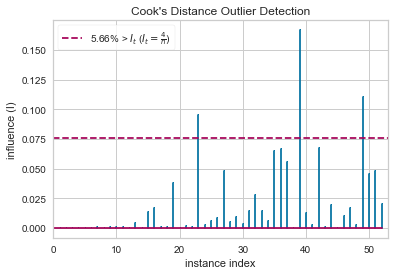

ajmer - Cumulative Months


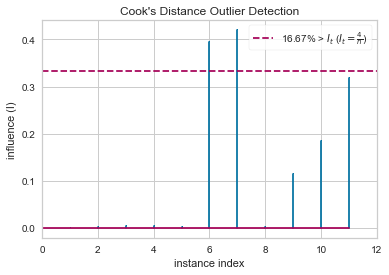

ajmer - Monthly


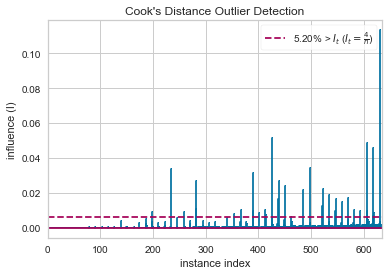

ajmer - Yearly


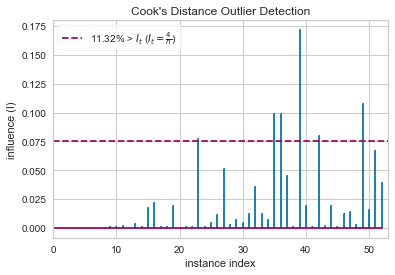

ajmer - Cumulative Months


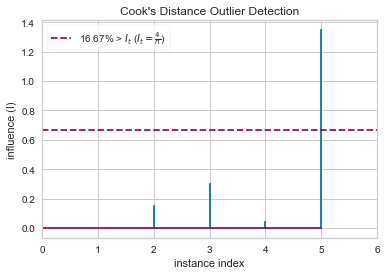

ajmer - Monthly


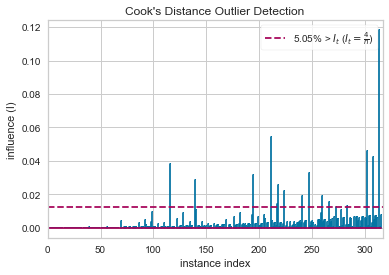

In [101]:
plot_cooks_distance(dict_rain_regions_yearly,'Yearly')
plot_cooks_distance(dict_rain_regions_monthly,'Cumulative Months')
plot_cooks_distance(dict_rain_regions_year_monthly,'Monthly')

plot_cooks_distance(dict_rain_monsoon_regions_yearly,'Yearly')
plot_cooks_distance(dict_rain_monsoon_regions_monthly,'Cumulative Months')
plot_cooks_distance(dict_rain_monsoon_regions_year_monthly,'Monthly')